# Description of the project

Service for the sale of used cars "Not beaten, not beautiful" is developing an application to attract new customers. In it, you can quickly find out the market value of your car. Historical data is available: technical characteristics, configurations and prices of cars. You need to build a model to determine the cost.

The customer is important:
- quality of prediction;
- prediction speed;
- studying time.

# Description of data

The data is in the `/datasets/autos.csv` file.

Signs:

- DateCrawled - date of downloading the profile from the database
- VehicleType - type of car body
- RegistrationYear — year of car registration
- Gearbox - type of gearbox
- Power - power (hp)
- Model - car model
- Kilometer - mileage (km)
- RegistrationMonth — month of car registration
- FuelType — type of fuel
- Brand - car brand
- NotRepaired - was the car under repair or not
- DateCreated — date of creation of the questionnaire
- NumberOfPictures - the number of photos of the car
- PostalCode - postal code of the owner of the profile (user)
- LastSeen - date of last user activity

Target feature:
- Price - price (EUR)

# Action plan

1. Download data

2. Analyze and prepare data

3. Build price forecast models and evaluate their quality

4. Conclusion

Notes:

- The RMSE metric will be applied to assess the quality of models
- Gradient boosting model will be implemented using the LightGBM library
- Since the gradient boosting model can be trained for a long time, only 2-3 parameters will be changed for it

# Loading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

import lightgbm as lgb

pd.set_option('display.max_row',100)
pd.set_option('display.max_columns',100)

In [2]:
df = pd.read_csv('/datasets/autos.csv', sep=',')
# df = pd.read_csv('datasets/autos.csv', sep=',')
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


# Data analysis and preparation

The following factors affect the price calculation:
<br>VehicleType, RegistrationYear, Gearbox, Power, Kilometer, RegistrationMonth, FuelType, NotRepaired, Price.
<br>We will continue to work with them.

With the number of photos is a moot point. But we will assume that their number does not affect the price.

In [5]:
df_n = df[['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Kilometer', 
           'FuelType', 'NotRepaired', 'Price']]

## Car type

Total number of rows and number of missing values

In [6]:
a = df_n['VehicleType'].count()
b = df_n['VehicleType'].isna().sum()
print(a)
print(b)
100*b/a

316879
37490


11.831014361948883

Let's take a look at the data

In [7]:
df_n['VehicleType'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

Remove missing values

In [8]:
index = df_n[df_n['VehicleType'].isna() == True].index
df_n = df_n.drop(index).reset_index(drop=True)
df_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316879 entries, 0 to 316878
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316879 non-null  object
 1   RegistrationYear  316879 non-null  int64 
 2   Gearbox           307016 non-null  object
 3   Power             316879 non-null  int64 
 4   Kilometer         316879 non-null  int64 
 5   FuelType          301279 non-null  object
 6   NotRepaired       266296 non-null  object
 7   Price             316879 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


## Year of registration

Total number of rows and number of missing values

In [9]:
a = df_n['RegistrationYear'].count()
b = df_n['RegistrationYear'].isna().sum()
print(a)
print(b)
100*b/a

316879
0


0.0

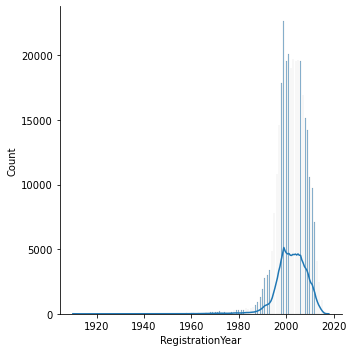

In [10]:
sns.displot(df_n['RegistrationYear'],kde=True)

The spread is very strong.
<br>Let's limit the minimum year - 1990. After this year, it seems to me, the car can not be considered rare. Everything that used to be a rarity and the price for it is determined based on specific characteristics.
<br>And the limitation of the maximum year is today, 2020.

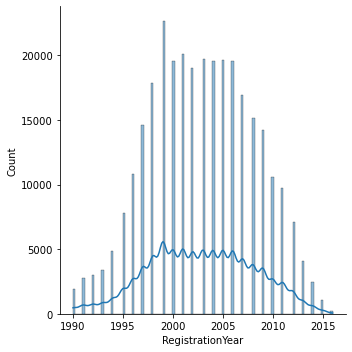

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308258 entries, 0 to 308257
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       308258 non-null  object
 1   RegistrationYear  308258 non-null  int64 
 2   Gearbox           299139 non-null  object
 3   Power             308258 non-null  int64 
 4   Kilometer         308258 non-null  int64 
 5   FuelType          293559 non-null  object
 6   NotRepaired       259858 non-null  object
 7   Price             308258 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 18.8+ MB


In [11]:
index = df_n.loc[(df_n['RegistrationYear'] < 1990) | (df_n['RegistrationYear'] > 2016)].index
df_n = df_n.drop(index).reset_index(drop=True)
sns.displot(df_n['RegistrationYear'],kde=True)
plt.show()
df_n.info()

## Gearbox type

Total number of rows and number of missing values

In [12]:
a = df_n['Gearbox'].count()
b = df_n['Gearbox'].isna().sum()
print(a)
print(b)
100*b/a

299139
9119


3.0484156194946164

Let's take a look at the data

In [13]:
df_n['Gearbox'].sort_values().unique()

array(['auto', 'manual', nan], dtype=object)

Remove missing values

In [14]:
index = df_n[df_n['Gearbox'].isna() == True].index
df_n = df_n.drop(index).reset_index(drop=True)
df_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299139 entries, 0 to 299138
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       299139 non-null  object
 1   RegistrationYear  299139 non-null  int64 
 2   Gearbox           299139 non-null  object
 3   Power             299139 non-null  int64 
 4   Kilometer         299139 non-null  int64 
 5   FuelType          286188 non-null  object
 6   NotRepaired       254749 non-null  object
 7   Price             299139 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 18.3+ MB


## Power

Total number of rows and number of missing values

In [15]:
a = df_n['Power'].count()
b = df_n['Power'].isna().sum()
print(a)
print(b)
100*b/a

299139
0


0.0

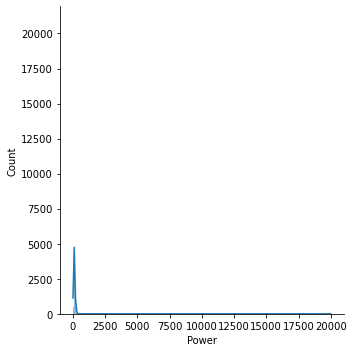

In [16]:
sns.displot(df_n['Power'],kde=True)

The spread is very strong.
<br>Minimum limit - 20. In case someone decides to put up for sale a car similar in characteristics to Zaporozhets.
<br>And the maximum limit is 700. This is the power of the most powerful tractor to date. Of course, there are also capacities of more than 1000, up to 1600, but they are extremely few and unlikely to be sold on this site.

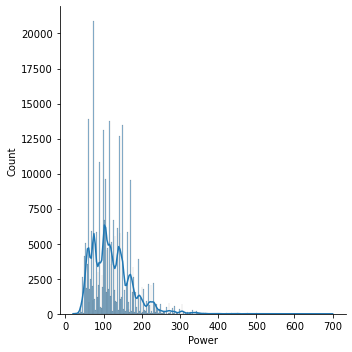

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279581 entries, 0 to 279580
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       279581 non-null  object
 1   RegistrationYear  279581 non-null  int64 
 2   Gearbox           279581 non-null  object
 3   Power             279581 non-null  int64 
 4   Kilometer         279581 non-null  int64 
 5   FuelType          269101 non-null  object
 6   NotRepaired       243180 non-null  object
 7   Price             279581 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 17.1+ MB


In [17]:
index = df_n.loc[(df_n['Power'] < 20) | (df_n['Power'] > 700)].index
df_n = df_n.drop(index).reset_index(drop=True)
sns.displot(df_n['Power'],kde=True)
plt.show()
df_n.info()

## Mileage

Total number of rows and number of missing values

In [18]:
a = df_n['Kilometer'].count()
b = df_n['Kilometer'].isna().sum()
print(a)
print(b)
100*b/a

279581
0


0.0

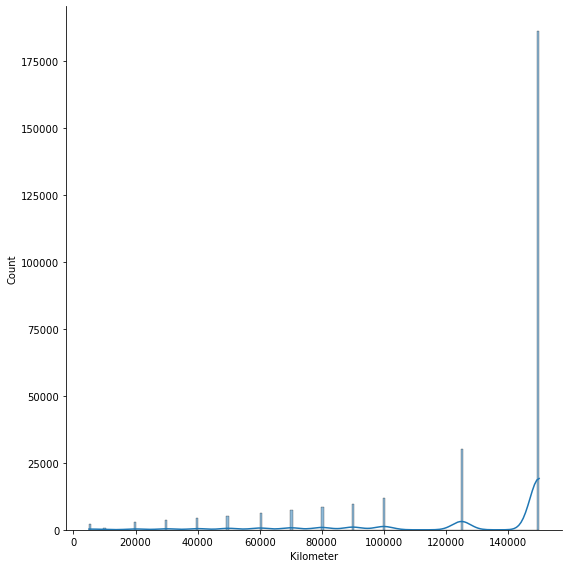

In [19]:
sns.displot(df_n['Kilometer'],height=8,aspect=1,kde=True)

Пробег может быть любым в данном случае

## Fuel type

Total number of rows and number of missing values

In [20]:
a = df_n['FuelType'].count()
b = df_n['FuelType'].isna().sum()
print(a)
print(b)
100*b/a

269101
10480


3.8944485527738655

Let's take a look at the data

In [21]:
df_n['FuelType'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

Remove missing values

In [22]:
index = df_n[df_n['FuelType'].isna() == True].index
df_n = df_n.drop(index).reset_index(drop=True)
df_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269101 entries, 0 to 269100
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       269101 non-null  object
 1   RegistrationYear  269101 non-null  int64 
 2   Gearbox           269101 non-null  object
 3   Power             269101 non-null  int64 
 4   Kilometer         269101 non-null  int64 
 5   FuelType          269101 non-null  object
 6   NotRepaired       236284 non-null  object
 7   Price             269101 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 16.4+ MB


## Repair mark

Total number of rows and number of missing values

In [23]:
a = df_n['NotRepaired'].count()
b = df_n['NotRepaired'].isna().sum()
print(a)
print(b)
100*b/a

236284
32817


13.888794840107668

Let's take a look at the data

In [24]:
df_n['NotRepaired'].sort_values().unique()

array(['no', 'yes', nan], dtype=object)

Remove missing values

In [25]:
index = df_n[df_n['NotRepaired'].isna() == True].index
df_n = df_n.drop(index).reset_index(drop=True)
df_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236284 entries, 0 to 236283
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       236284 non-null  object
 1   RegistrationYear  236284 non-null  int64 
 2   Gearbox           236284 non-null  object
 3   Power             236284 non-null  int64 
 4   Kilometer         236284 non-null  int64 
 5   FuelType          236284 non-null  object
 6   NotRepaired       236284 non-null  object
 7   Price             236284 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 14.4+ MB


In [26]:
df_n['NotRepaired'] = df_n['NotRepaired'].fillna('no')
df_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236284 entries, 0 to 236283
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       236284 non-null  object
 1   RegistrationYear  236284 non-null  int64 
 2   Gearbox           236284 non-null  object
 3   Power             236284 non-null  int64 
 4   Kilometer         236284 non-null  int64 
 5   FuelType          236284 non-null  object
 6   NotRepaired       236284 non-null  object
 7   Price             236284 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 14.4+ MB


## Price

Total number of rows and number of missing values

In [27]:
a = df_n['Price'].count()
b = df_n['Price'].isna().sum()
print(a)
print(b)
100*b/a

236284
0


0.0

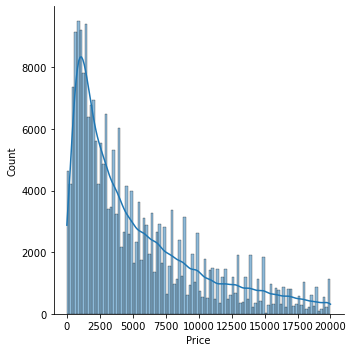

In [28]:
sns.displot(df_n['Price'],kde=True)

The spread is very strong.
<br>Minimum limit - 100. You can't find a cheaper price on European sites.
<br>In this case, you can do without limiting the maximum.

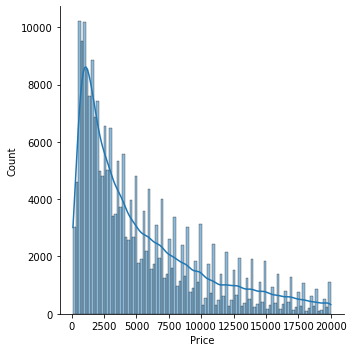

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232759 entries, 0 to 232758
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       232759 non-null  object
 1   RegistrationYear  232759 non-null  int64 
 2   Gearbox           232759 non-null  object
 3   Power             232759 non-null  int64 
 4   Kilometer         232759 non-null  int64 
 5   FuelType          232759 non-null  object
 6   NotRepaired       232759 non-null  object
 7   Price             232759 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 14.2+ MB


In [29]:
index = df_n.loc[(df_n['Price'] < 100)].index
df_n = df_n.drop(index).reset_index(drop=True)
sns.displot(df_n['Price'],kde=True)
plt.show()
df_n.info()

# Building price forecast models

First, we build simple linear regression, decision tree, and random forest models without gradient boosting.
<br>Then the same models, but with gradient boosting.

Let's transform categorical features into quantitative ones

In [30]:
df_ohe = pd.get_dummies(df_n, drop_first=True)
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232759 entries, 0 to 232758
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   RegistrationYear         232759 non-null  int64
 1   Power                    232759 non-null  int64
 2   Kilometer                232759 non-null  int64
 3   Price                    232759 non-null  int64
 4   VehicleType_convertible  232759 non-null  uint8
 5   VehicleType_coupe        232759 non-null  uint8
 6   VehicleType_other        232759 non-null  uint8
 7   VehicleType_sedan        232759 non-null  uint8
 8   VehicleType_small        232759 non-null  uint8
 9   VehicleType_suv          232759 non-null  uint8
 10  VehicleType_wagon        232759 non-null  uint8
 11  Gearbox_manual           232759 non-null  uint8
 12  FuelType_electric        232759 non-null  uint8
 13  FuelType_gasoline        232759 non-null  uint8
 14  FuelType_hybrid          232759 non-

Divide the sample into sets with features and a target feature

In [31]:
features = df_ohe.drop(['Price'], axis=1)
target = df_ohe['Price']

Let's break the sets into three subsets: train, validation and test in the ratio `3:1:1`

In [32]:
features_train, features_valid = train_test_split(features, test_size=0.20, random_state=12345)
features_train, features_test = train_test_split(features_train, test_size=0.25, random_state=12345)

target_train, target_valid = train_test_split(target, test_size=0.20, random_state=12345)
target_train, target_test = train_test_split(target_train, test_size=0.25, random_state=12345)

print(features.shape)
print(target.shape)
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(232759, 18)
(232759,)
(139655, 18)
(139655,)
(46552, 18)
(46552,)
(46552, 18)
(46552,)


Scale features

In [33]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

## Linear regression

In [34]:
%%time
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
predictions = model_lr.predict(features_valid)
rmse = mean_squared_error(target_valid, predictions) ** 0.5
print('RMSE linear regression:', rmse)

RMSE линейной регрессии: 2538.51881063271
Wall time: 64 ms


## Decision tree

In [35]:
%%time
param_grid = {'max_depth': range(1,100,10)}

dtr = GridSearchCV(estimator=DecisionTreeRegressor(random_state=12345), param_grid=param_grid, cv=5)
dtr.fit(features_train, target_train)
dtr.best_params_

Wall time: 14.9 s


{'max_depth': 11}

In [36]:
predictions = dtr.predict(features_valid)
rmse = mean_squared_error(target_valid, predictions) ** 0.5
print('RMSE decision tree:', rmse)

RMSE решающего дерева: 1944.7930767783564


## Random forest

In [37]:
%%time
param_grid = {'n_estimators': range(1,40,10), 'max_depth': range(1,40,10)}

rfr = GridSearchCV(estimator=RandomForestRegressor(random_state=12345), param_grid=param_grid, cv=5)
rfr.fit(features_train, target_train)
rfr.best_params_

Wall time: 3min 5s


{'max_depth': 21, 'n_estimators': 31}

In [38]:
predictions = rfr.predict(features_valid)
rmse = mean_squared_error(target_valid, predictions) ** 0.5
print('RMSE random forest:', rmse)

RMSE случайного леса: 1740.8948520419317


## LightGBM

In [39]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.005,
    'verbose': 0,
    "max_depth": 8,
    "num_iterations": 20000,
    "n_estimators": 1000
}

In [40]:
%%time
gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(features_train, target_train, 
        eval_set=[(features_valid, target_valid)],
        eval_metric='rmse', verbose=0)

print('RMSE LightGBM:', gbm.best_score_['valid_0']['rmse'])

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSE LightGBM: 1703.0804843902376
Wall time: 1min 19s


# Checking models on a test dataset

In [41]:
predictions = model_lr.predict(features_test)
rmse = mean_squared_error(target_test, predictions) ** 0.5
print('RMSE Linear Regression:', rmse)

predictions = dtr.predict(features_test)
rmse = mean_squared_error(target_test, predictions) ** 0.5
print('RMSE Decision Tree:', rmse)

predictions = rfr.predict(features_test)
rmse = mean_squared_error(target_test, predictions) ** 0.5
print('RMSE random forest:', rmse)

predictions = gbm.predict(features_test)
rmse = mean_squared_error(target_test, predictions) ** 0.5
print('RMSE LightGBM:', rmse)

RMSE линейной регрессии: 2543.096721106801
RMSE решающего дерева: 1953.9883768832394
RMSE случайного леса: 1766.4755648973367
RMSE LightGBM: 1736.5792314701307


Importance of factors

In [42]:
feature_importances = pd.DataFrame(gbm.feature_importances_,
                                   index = features.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Power,222183
RegistrationYear,153767
Kilometer,72624
VehicleType_sedan,22004
Gearbox_manual,20942
FuelType_gasoline,17193
VehicleType_wagon,14505
VehicleType_convertible,11583
FuelType_petrol,11413
VehicleType_suv,10221


# Conclusion

As can be seen from the results on the test dataset, LightGBM takes first place, and random forest is in second place.
<br>It should also be taken into account that LightGBM works, in this case, 5 times faster than random forest

# Appendix 1

Combine train and validation datasets

In [43]:
features_tr_v = np.concatenate([features_train, features_valid])
target_tr_v = np.concatenate([target_train, target_valid])

print(features_train.shape)
print(features_valid.shape)
print(features_tr_v.shape)
print()
print(target_train.shape)
print(target_valid.shape)
print(target_tr_v.shape)

(139655, 18)
(46552, 18)
(186207, 18)

(139655,)
(46552,)
(186207,)


Linear Regression

In [44]:
%%time
model_lr = LinearRegression()
model_lr.fit(features_tr_v, target_tr_v)
predictions = model_lr.predict(features_test)
rmse = mean_squared_error(target_test, predictions) ** 0.5
print('RMSE Linear Regression:', rmse)

RMSE линейной регрессии: 2543.0864176980517
Wall time: 119 ms


LightGBM

In [45]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.005,
    'verbose': 0,
    "max_depth": 8,
    "num_iterations": 20000,
    "n_estimators": 1000
}

In [46]:
%%time
gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(features_tr_v, target_tr_v, 
        eval_set=[(features_test, target_test)],
        eval_metric='rmse', verbose=0)

print('RMSE LightGBM:', gbm.best_score_['valid_0']['rmse'])

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSE LightGBM: 1731.5867546922336
Wall time: 1min 41s


Hmm, predictions haven't improved. Perhaps I missed something.

# Appendix 2

We will issue the predictions of the test sample in the form of a dataset

In [47]:
predictions = pd.DataFrame(gbm.predict(features_test),columns=['Predictions'])

We combine all the features and predictions of the test set, and also calculate the difference between predictions and answers

In [48]:
diff = df_n.merge(target_test, left_index=True, right_index=True).reset_index(drop=True)
diff = diff.merge(predictions, left_index=True, right_index=True)
diff['difference'] = abs(diff['Price_y'] - diff['Predictions'])
diff.head()

,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,FuelType,NotRepaired,Price_x,Price_y,Predictions,difference
0,sedan,1995,manual,102,150000,petrol,yes,650,650,8750.334081,8100.334081
1,sedan,2007,auto,218,20000,petrol,no,18000,18000,8041.594846,9958.405154
2,sedan,2007,manual,95,100000,petrol,no,6990,6990,647.778852,6342.221148
3,wagon,1998,auto,193,150000,petrol,no,2100,2100,2560.451756,460.451756
4,sedan,2006,auto,105,100000,gasoline,no,7000,7000,1799.266361,5200.733639


I think 500 euros can fluctuate the price of the same car. The percentage of errors less than 500 euros is equal to:

In [49]:
100 * diff.loc[diff['difference'] < 500, 'difference'].count() / diff['difference'].count()

9.677350060147791

Less than 10% is not great. Let's look at the lines

In [50]:
under_500 = diff.query('difference < 500')
under_500

,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,FuelType,NotRepaired,Price_x,Price_y,Predictions,difference
3,wagon,1998,auto,193,150000,petrol,no,2100,2100,2560.451756,460.451756
9,wagon,1999,manual,125,150000,gasoline,no,900,900,1347.356065,447.356065
38,small,2013,auto,75,60000,petrol,no,9750,9750,10087.475614,337.475614
39,sedan,2009,manual,185,150000,gasoline,no,7700,7700,7412.350665,287.649335
49,bus,2008,auto,140,150000,gasoline,no,5600,5600,5267.602453,332.397547
...,...,...,...,...,...,...,...,...,...,...,...
46461,sedan,2003,manual,150,150000,gasoline,yes,1950,1950,1702.884910,247.115090
46485,sedan,2001,manual,116,70000,petrol,no,2250,2250,1791.012698,458.987302
46488,wagon,1999,manual,116,150000,petrol,no,1350,1350,1331.405901,18.594099
46522,small,1997,manual,54,150000,petrol,no,700,700,364.402627,335.597373


In [51]:
more_500 = diff.query('difference > 500')
more_500

,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,FuelType,NotRepaired,Price_x,Price_y,Predictions,difference
0,sedan,1995,manual,102,150000,petrol,yes,650,650,8750.334081,8100.334081
1,sedan,2007,auto,218,20000,petrol,no,18000,18000,8041.594846,9958.405154
2,sedan,2007,manual,95,100000,petrol,no,6990,6990,647.778852,6342.221148
4,sedan,2006,auto,105,100000,gasoline,no,7000,7000,1799.266361,5200.733639
5,small,2002,manual,50,150000,petrol,no,750,750,2827.043146,2077.043146
...,...,...,...,...,...,...,...,...,...,...,...
46547,wagon,2012,manual,156,125000,petrol,no,13850,13850,662.592511,13187.407489
46548,sedan,2002,manual,116,150000,lpg,no,3200,3200,960.129037,2239.870963
46549,wagon,1998,manual,125,150000,petrol,no,1600,1600,6584.429737,4984.429737
46550,sedan,2006,manual,105,150000,gasoline,no,5900,5900,891.376037,5008.623963
